# Adaptive grid sampler tutorial 
### August George, Zuckerman Lab, OHSU, 2023

This method iterates through an increasing data batch size until all the data is included (i.e. 'data tempering'). 

After initialization, an adaptive multi-grid approach is used to evaluate the log-likelihood surface.

We will use a a toy model to test the adaptive grid sampler (in `toy_model.py`):

$y=a\sin(bx)+ax\sin(bx^2)$ where $a=5$, $b=0.1$, and $t=0,0.05,...,5$ with Gaussian noise added: $y_{obs} = y_{true} + \epsilon$ where $\epsilon \sim N(0,1)$

We will also use a Normal log-likelihood function. 

Log-likelihood functions are expected to have the form f(x,args) where x = parameters, args = [data, additional arguments] 

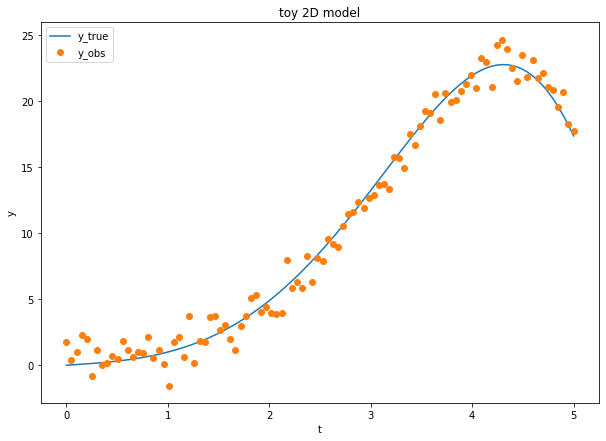

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys 
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from pyGridSampler import grid_sampler as gs
from pyGridSampler import grid_tools as gt
import toy_model  # seperate file containing log-likelihood and model functions


# setup toy model
np.random.seed(0)
x1_true = 5
x2_true = 0.1
sigma_true = 1
t_full = np.linspace(0, 5, 100)
x_truths = [x1_true, x2_true]

y_true = toy_model.f(x1_true,x2_true,t_full)
y_obs = y_true + np.random.normal(0,sigma_true,np.size(y_true))
log_like_func = toy_model.log_likelihood

# plot synthetic data
plt.figure(figsize=(10,7))
plt.plot(t_full, y_true, label='y_true')
plt.plot(t_full, y_obs, 'o', label='y_obs')
plt.title('toy 2D model')
plt.ylabel('y')
plt.xlabel('t')
plt.legend()
plt.show()

For the grid sampler using data-tempering, we need to create a data tempering list of lists containing increasingly more data. 

Each iteration of the algorithm includes an additional data point - i.e. the next list in the data tempering list. 

For this example we increment the data, but other strategies could be used (e.g. first data point, last data point, mid point, etc)

Example: tempering_list = [[y1], [y1,y2], ... [y1,y2,...yN]]

Additional log-likelihood arguments can be packed into this list as well.

In [2]:
def create_tempering_list(log_like_args):
    # creates a list of arguments for the log-likelihood function at each tempering stage
    y_obs = log_like_args[0]
    t_full = log_like_args[1]
    n_data_points = len(y_obs)

    # get a list of data indices for data tempering - e.g. [[0], [0,1], [0,1,2]]
    # each list index corresponds to a data tempering stage
    idx_sublist = gt.get_sorted_idx_sublists(y_obs)

    # get y_obs and t lists for each data tempering stage
    # e.g. t_tempering_list = [t[0], t[0,1], t[0,1,2]]
    t_sublist = gt.get_sorted_sublists_from_idx(idx_sublist, t_full)
    y_obs_sublist = gt.get_sorted_sublists_from_idx(idx_sublist, y_obs)

    # at a given tempering stage n, this list contains data[:n], t[:n] for the log-likelihood calculation
    args_tempering_list = [[y_obs_sublist[i], t_sublist[i]] for i in range(n_data_points)]
    return args_tempering_list

args_list = create_tempering_list([y_obs, t_full])

Then we make a set of parameter boundaries and list of direction to add neighboring points during the expansion stage. 

For example, [[1,1],] would add a single point for each existing grid point in the (1,1) direction

Finally we set the initial conditions and hyperparameters for the sampler, and then run the sampler

In [3]:
# configure sampler parameters
x_bounds = [(0,10), (0,2)]
x_shifts = [[1,1], [-1,1], [1,-1], [-1,-1], [1,0], [-1,0], [0,1], [0,-1]]


init_data_size = 2 # use 2 data points initially
init_grid_resolution = 10 # n points per parameter -> total grid size =  n^n_dim points
ess_min = 500  # target effective size threshold. larger ess_min --> denser grid 
delta = 0.01 # keep smallest set of grid points whose weights sum to 1-delta. larger delta --> remove more gridpoints


# create sampler class
sampler = gs.GridSampler(log_like_func,args_list,y_obs, x_bounds, x_shifts)

# initialize and run sampler
grid_resolution, data_size, grid, spacing, log_likelihoods, rel_prob, weights, ess  = sampler.initialize_and_sample(init_grid_resolution, init_data_size, ess_min, delta, n_processes=4, max_iter=100)


Intialization: data_size=2, grid_resolution=23, n_grid_points=529, ESS=507.33340773401375: : 13it [00:02,  4.44it/s]
Processing: data_size=100, n_grid_points=4748, ESS=1276.0242986214855: 100%|██████████| 98/98 [09:34<00:00,  5.86s/it]


once the samples are collected we can plot the marginals, 2d histogram, and compare to the brute force grid evaluation

In [9]:
def plot_grid(sampler, i):
    grid_i = sampler.output[i]

    # 1d marginals distribution
    fig = gt.plot_grid_marginals(grid, x_bounds, x_truths)

    plt.figure(figsize=(10,7))
    # 2d distribution
    x = grid[:, 0]
    y = grid[:, 1]
    plt.hist2d(x, y, bins=(200,200), cmap='plasma', density=True, range=(x_bounds))
    plt.colorbar(label='density')

    # Set axis labels
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

    # Show the plot
    plt.show()

print(sampler.output)

[]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def f(a, b, x):
    return a * np.sin(b * x) + a * x * np.sin(b * x**2)



def log_likelihood(params, args):
    a, b = params
    y_obs, x = args
    y_pred = f(a, b, x)

    # Assuming Gaussian likelihood with a known standard deviation
    sigma = 1
    n = len(y_obs)
    ll = -0.5 * n * np.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2)) * np.sum((y_obs - y_pred)**2)
    return ll

for i in [2,5,10,25,50,100]:
    np.random.seed(0)
    # Set the true values of a and b
    a_true = 5
    b_true = 0.1
    scale = 1
    # Define the range of x values
    x_full = np.linspace(0, 5, 100)
  
    x = x_full[:i]
    # Generate the true function values
    y_true = f(a_true, b_true, x)

    # Add correlated noise to the true function values to generate the observed data
    y_obs = y_true + np.random.normal(0,scale,np.size(y_true))

    a_vals = np.linspace(0, 10, 200)
    b_vals = np.linspace(0, 2, 200)
    A, B = np.meshgrid(a_vals, b_vals)
    log_likelihood_grid = np.zeros((len(a_vals), len(b_vals)))
    for i, a in enumerate(a_vals):
        for j, b in enumerate(b_vals):
            params = [a, b]
            args = [y_obs, x]
            log_likelihood_grid[j, i] = log_likelihood(params, args)

    # Scale log_likelihood_grid values between 0 and 1
    if np.ptp(log_likelihood_grid) == 0:
        log_likelihood_grid_scaled = np.zeros_like(log_likelihood_grid)
    else:
        log_likelihood_grid_scaled = (log_likelihood_grid - np.min(log_likelihood_grid)) / (np.max(log_likelihood_grid) - np.min(log_likelihood_grid))
 
  
    likelihood_grid = np.exp(log_likelihood_grid)

    if np.ptp(likelihood_grid) == 0:
        likelihood_grid_scaled = np.ones_like(likelihood_grid)
    else:
        likelihood_grid_scaled = (likelihood_grid - np.min(likelihood_grid))/np.ptp(likelihood_grid)

    # Create a heatmap of the scaled log-likelihood values
    plt.figure(figsize=(10,7))
    plt.pcolormesh(A, B, likelihood_grid_scaled, cmap='jet')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(f'scaled likelihood surface: {np.size(x)} data points')
    plt.colorbar()
    plt.show()

    # Compute the marginal distributions by summing along one axis
    marginal_A = np.sum(likelihood_grid, axis=0)  # Sum along the rows (axis=0)
    marginal_B = np.sum(likelihood_grid, axis=1)  # Sum along the columns (axis=1)

    # Normalize the marginals so that their integral is 1
    marginal_A /= np.sum(marginal_A)
    marginal_B /= np.sum(marginal_B)

    # Compute the bin width for histograms
    bin_width_A = a_vals[1] - a_vals[0]
    bin_width_B = b_vals[1] - b_vals[0]

    # Plot the histograms
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

    ax1.hist(a_vals, bins=len(a_vals), weights=marginal_A, density=True, alpha=0.75, histtype='step', color='black')
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel('density')
    ax1.set_title(r'$x_1$ distribution')

    ax2.hist(b_vals, bins=len(b_vals), weights=marginal_B, density=True, alpha=0.75, histtype='step', color='black')
    ax2.set_xlabel(r'$x_2$')
    ax2.set_ylabel('density')
    ax2.set_title(r'$x_2$ distribution')

    plt.tight_layout()
    plt.show()

